In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import pandas as pd
import pprint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import csv
import json
import seaborn as sns
from scipy import stats
from scipy.ndimage.filters import gaussian_filter

mpl.rcParams['figure.dpi'] = 144
mpl.rcParams['figure.figsize'] = (10, 7)

DATAFRAME_DIR = "/Users/jeremygordon/Google Drive/Academic/# UC Berkeley ISchool PhD/Research/# Current/Covert Embodied Choice/DataFrames"

## Load data frames (generated by build_dfs.ipynb)

In [3]:
trial_df = pd.read_pickle(DATAFRAME_DIR + '/trial_df.pickle')
tracking_df = pd.read_pickle(DATAFRAME_DIR + '/tracking_df.pickle')
fixation_df = pd.read_pickle(DATAFRAME_DIR + '/fixation_df.pickle')
subject_df = pd.read_pickle(DATAFRAME_DIR + '/subject_df.pickle')
with open("../ExperimentData/hands.json") as f:
    HANDS = json.load(f)

## Analyses

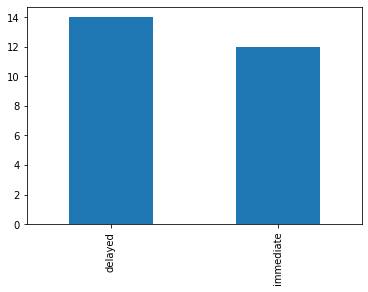

In [4]:
subject_df['condition'].value_counts().plot.bar()

In [5]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(tracking_df['hmd_x'], tracking_df['hmd_y'], tracking_df['hmd_z'], c='blue')
# ax.scatter(tracking_df['ctr_x'], tracking_df['ctr_y'], tracking_df['ctr_z'], c='red')
# ax.scatter(tracking_df['gaze_tgt_x'], tracking_df['gaze_tgt_y'], tracking_df['gaze_tgt_z'], c='green')

## Compare physiology in pre & post-adversary stages

### Each line a participant

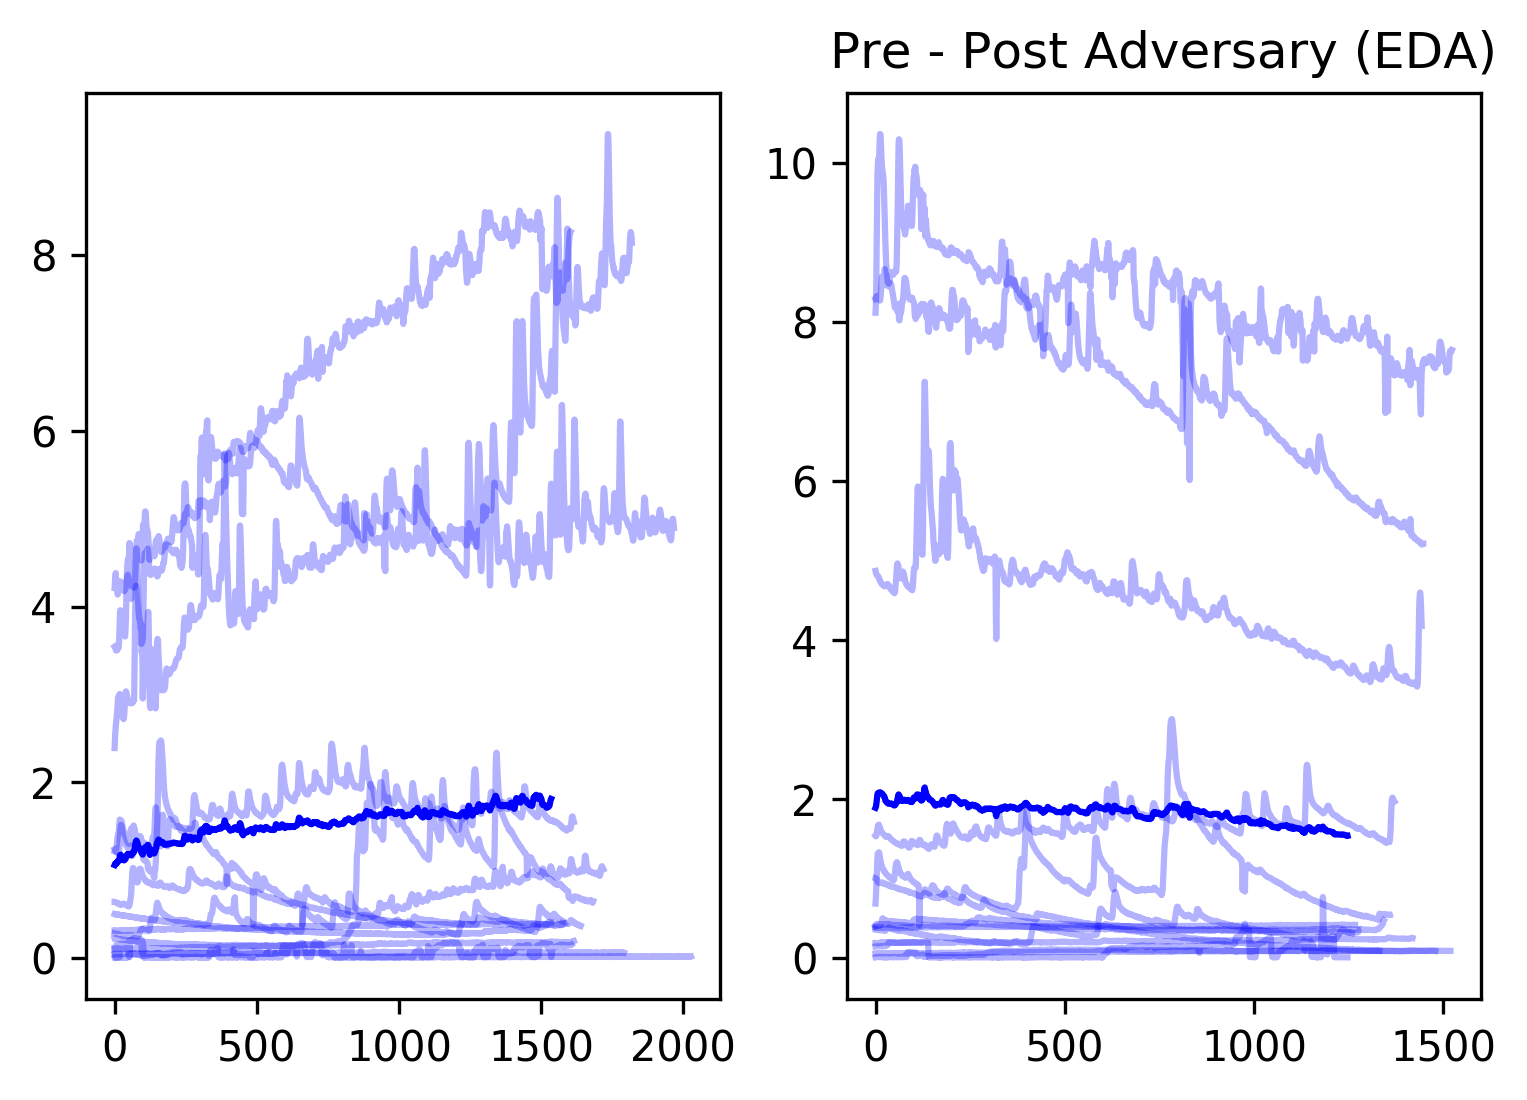

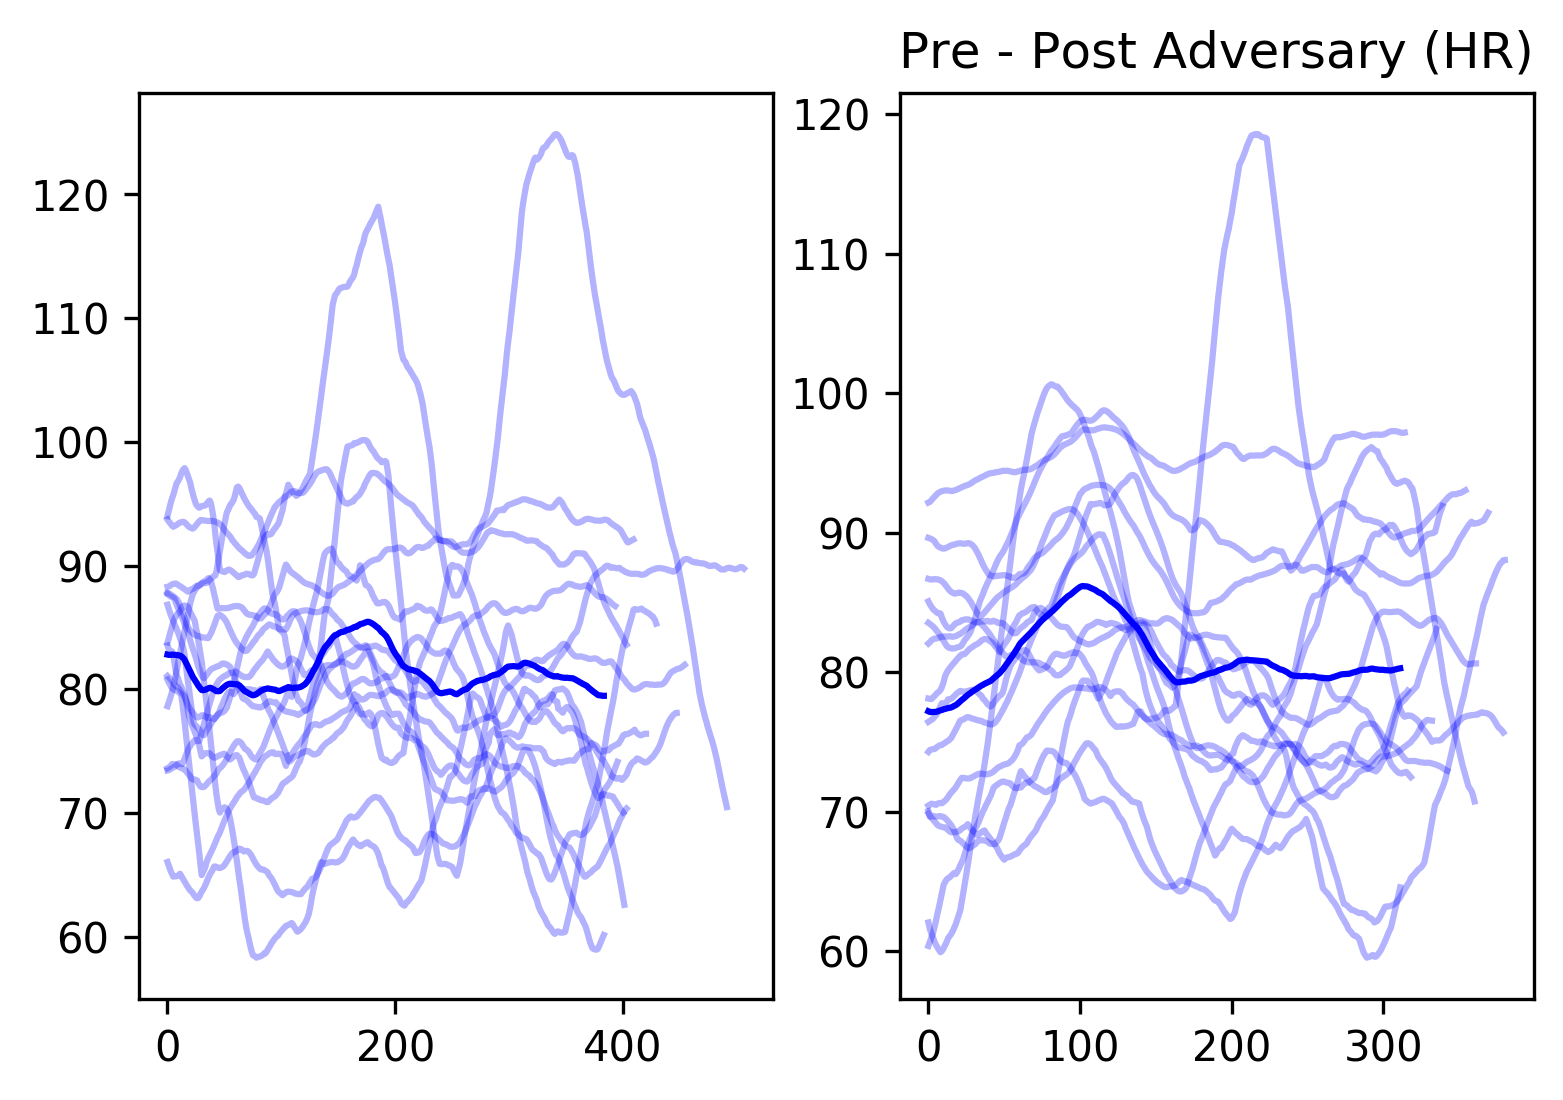

In [6]:
import random

for metric in ['eda', 'hr']:
    pre = []
    post = []
    for sona_id, row in subject_df.iterrows():
        if row.condition == 'delayed':
            pre.append(json.loads(row['%s_nadv' % metric]))
            post.append(json.loads(row['%s_adv' % metric]))

    min_pre = min([len(x) for x in pre])
    min_post = min([len(x) for x in post])

    fig, axs = plt.subplots(1, 2, dpi=300)
    for pre_series, post_series in zip(pre, post):
        axs[0].plot(pre_series, color='blue', alpha=0.3)
        axs[1].plot(post_series, color='blue', alpha=0.3)    

    pre_mean = np.vstack([arr[:min_pre] for arr in pre]).mean(axis=0)
    post_mean = np.vstack([arr[:min_post] for arr in post])[:, :min_post].mean(axis=0)
    axs[0].plot(pre_mean, color='blue')
    axs[1].plot(post_mean, color='blue')
    plt.title("Pre - Post Adversary (%s)" % metric.upper())
    plt.show()

### Controller time-series velocity comparison

#### Each line a trial

Text(0.5, 1.0, 'Distribution of selection durations')

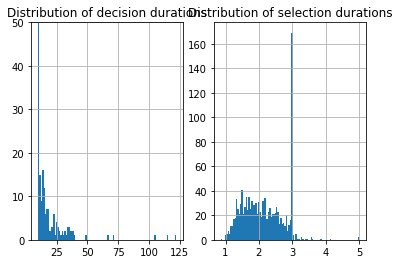

In [7]:
trial_df['decision_dur'] = trial_df['ts_selection'] - trial_df['ts_start']
trial_df['selection_dur'] = trial_df['ts_end'] - trial_df['ts_selection']

fig, axs = plt.subplots(1, 2)
trial_df['decision_dur'].hist(bins=100, ax=axs[0])
trial_df['selection_dur'].hist(bins=100, ax=axs[1])
axs[0].set_ylim((0, 50))
axs[0].set_title("Distribution of decision durations")
axs[1].set_title("Distribution of selection durations")

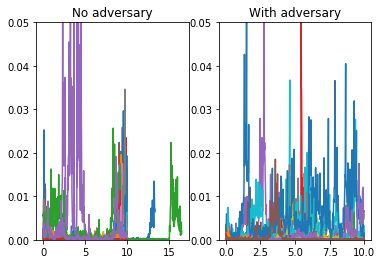

In [8]:
fig, axs = plt.subplots(1, 2)

max_plots = 50
i = 0
for key, row in trial_df.iterrows():
    if row.practice:
        continue
    tracks = tracking_df[
        (tracking_df.subject == row.subject) & \
        (tracking_df.trial == row.trial) & \
        (tracking_df.ts < row.ts_selection)
    ]
    ctr_vx = tracks[1:].ctr_x.values - tracks[:-1].ctr_x.values
    ctr_vy = tracks[1:].ctr_y.values - tracks[:-1].ctr_y.values
    ctr_vz = tracks[1:].ctr_z.values - tracks[:-1].ctr_z.values
    ctr_vel_norm = np.sqrt(ctr_vx ** 2 + ctr_vy ** 2 + ctr_vz ** 2)
    ax_id = 1 if row.with_adversary else 0
    xaxis = tracks.ts.values[:-1] - tracks.ts.values[0]
    axs[ax_id].plot(xaxis, ctr_vel_norm)
    i += 1
    if i > max_plots:
        break

axs[0].set_ylim((0, 0.05))
axs[1].set_ylim((0, 0.05))
axs[0].set_title("No adversary")
axs[1].set_title("With adversary")
plt.show()

### Top-down controller path, by choice

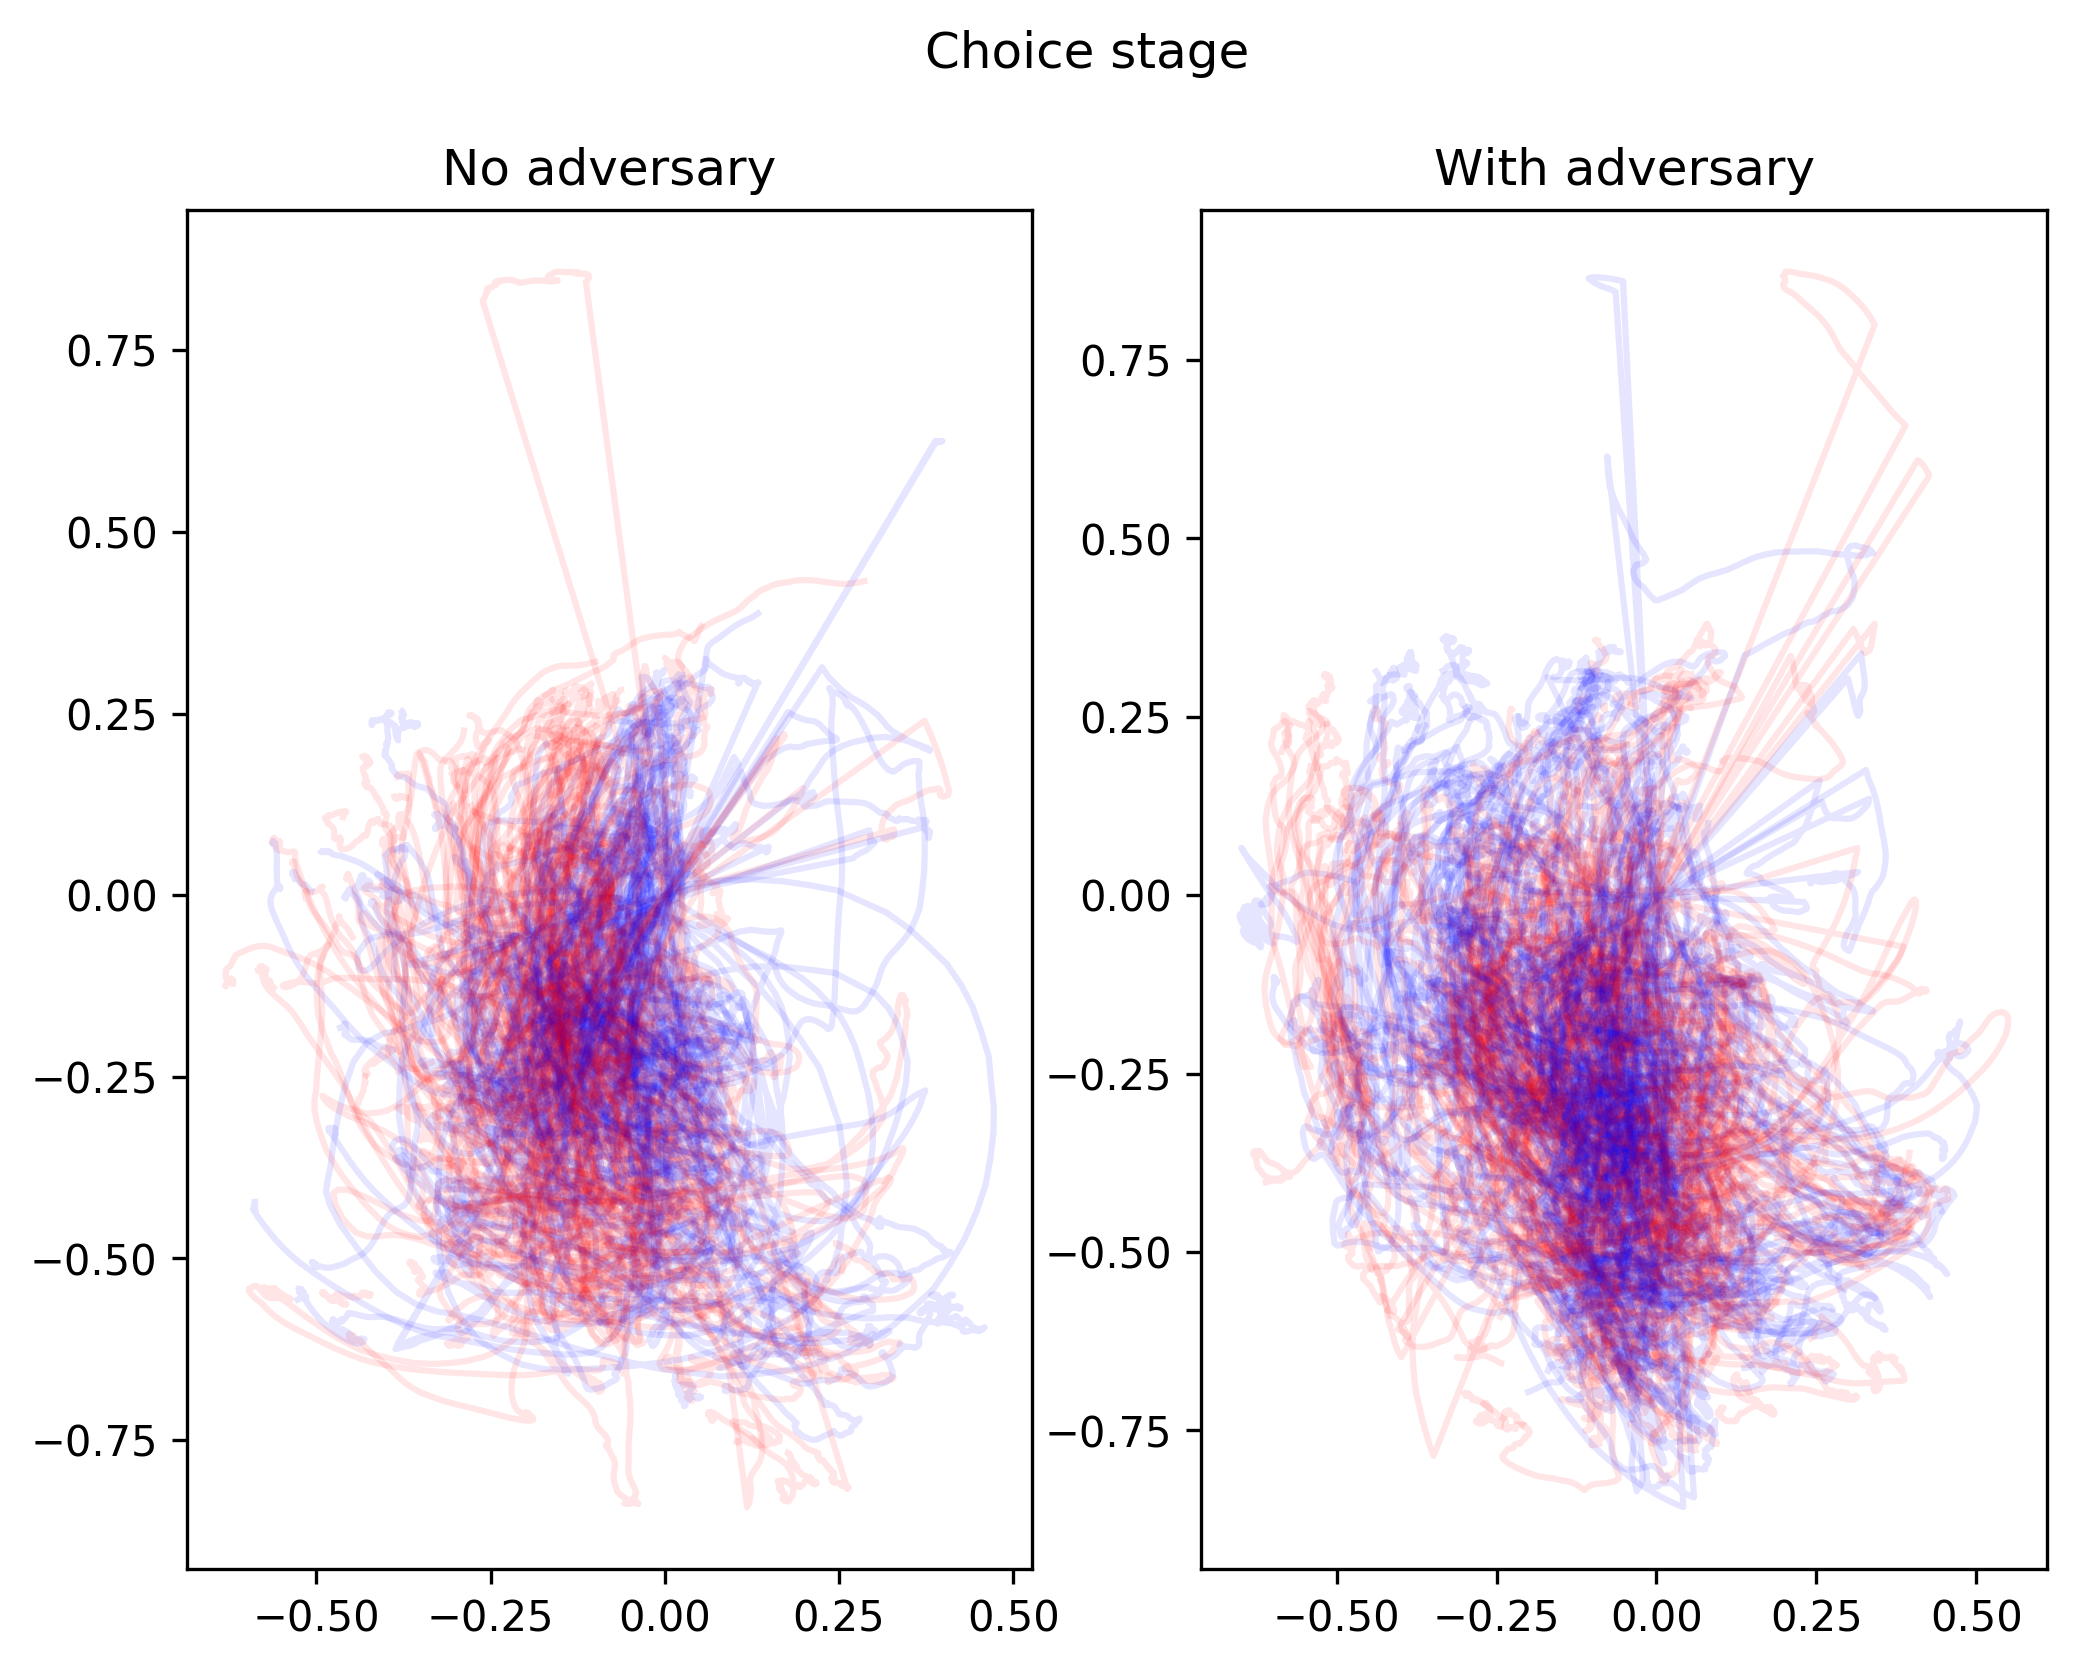

In [21]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(8, 6))

max_plots = 3000
i = 0
for key, row in trial_df.iterrows():
    if row.practice:
        continue
    tracks = tracking_df[
        (tracking_df.subject == row.subject) & \
        (tracking_df.trial == row.trial) & \
        (tracking_df.ts < row.ts_selection) & \
        (tracking_df.ts > row.ts_start)        
    ]
    chose_right = row.subject_choice == 1
    color = 'blue' if chose_right else 'red'
    ax_id = 1 if row.with_adversary else 0
    xaxis = tracks.ts.values[:-1] - tracks.ts.values[0]
    axs[ax_id].plot(tracks.ctr_y, tracks.ctr_x, c=color, alpha=0.1)
    i += 1
    if i > max_plots:
        break

axs[0].set_title("No adversary")
axs[1].set_title("With adversary")
plt.suptitle("Choice stage")
plt.show()

### Comparing fixation targets, with vs without adversary

TODO

* Show scatter points on hist
* Do this for counts as well as durations

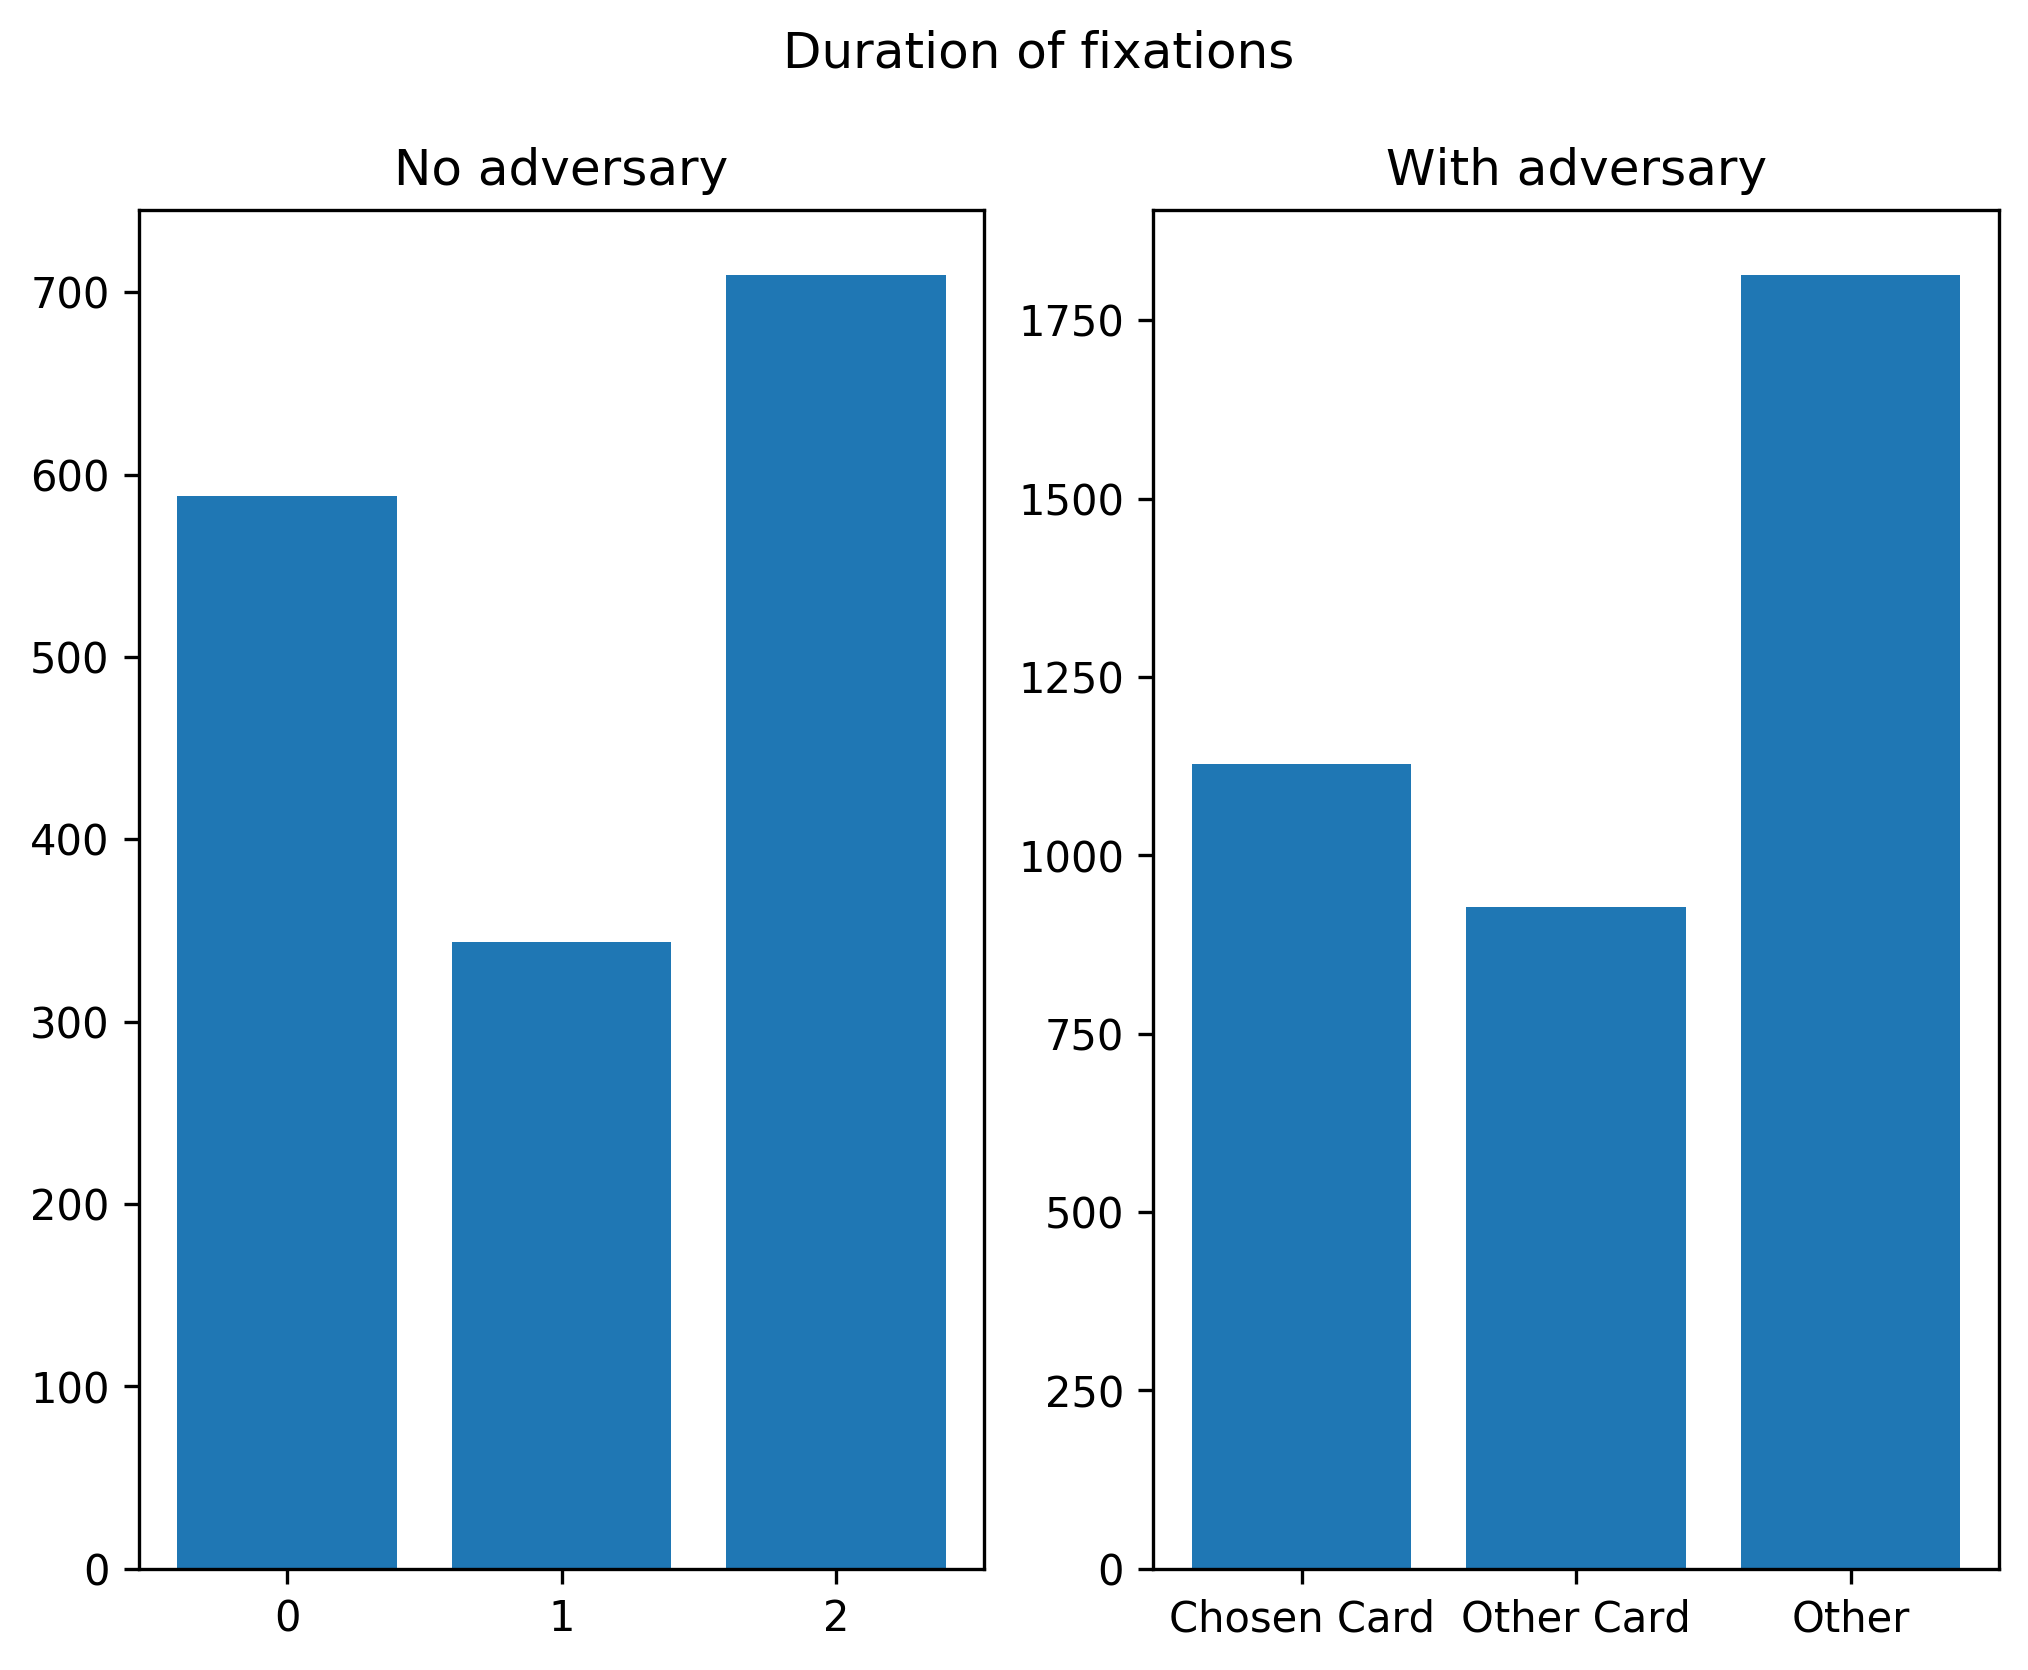

In [27]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(8, 6))

max_trials = 3000
i = 0
nadv_durations = [0, 0, 0]  # Chosen card, other card, elsewhere
adv_durations = [0, 0, 0]

for key, row in trial_df.iterrows():
    if row.practice:
        continue
    fixes = fixation_df[
        (fixation_df.subject == row.subject) & \
        (fixation_df.trial == row.trial) & \
        (fixation_df.stop_ts <= row.ts_selection) & \
        (fixation_df.start_ts > row.ts_start)        
    ]
    chose_right = row.subject_choice == 1
    for key, fix in fixes.iterrows():
        fixRight = fix.objectName == 'CardOnTable1'
        fixLeft = fix.objectName == 'CardOnTable0'
        fixCard = fixRight or fixLeft
        fixChosenCard = (fixRight and chose_right) or (fixLeft and not chose_right)
        idx = 0
        if fixChosenCard:
            idx = 0
        elif fixCard:
            idx = 1
        else:
            idx = 2
        if row.with_adversary:
            adv_durations[idx] += fix.duration
        else:
            nadv_durations[idx] += fix.duration
    i += 1
    if i > max_trials:
        break
            
ind = range(3)
axs[0].bar(ind, nadv_durations)
axs[0].set_xticks(ind)
axs[0].set_xticklabels('Chosen Card', 'Other Card', 'Other')
axs[1].bar(ind, adv_durations)
axs[1].set_xticks(ind)
axs[1].set_xticklabels('Chosen Card', 'Other Card', 'Other')

axs[0].set_title("No adversary")
axs[1].set_title("With adversary")
plt.suptitle("Duration of fixations")
plt.show()

### Raincloud version

In [30]:
fixation_df.columns

Index(['duration', 'objectName', 'start_ts', 'stop_ts', 'subject', 'trial',
       'with_adversary', 'target_group'],
      dtype='object')

In [ ]:
# Augment fixation_df with target_group and with_adversary columns for plot

for key, row in trial_df.iterrows():
    if row.practice:
        continue
    fixes = fixation_df[
        (fixation_df.subject == row.subject) & \
        (fixation_df.trial == row.trial) & \
        (fixation_df.stop_ts <= row.ts_selection) & \
        (fixation_df.start_ts > row.ts_start)        
    ]
    chose_right = row.subject_choice == 1
    for key, fix in fixes.iterrows():
        fixRight = fix.objectName == 'CardOnTable1'
        fixLeft = fix.objectName == 'CardOnTable0'
        fixCard = fixRight or fixLeft
        fixChosenCard = (fixRight and chose_right) or (fixLeft and not chose_right)
        target_group = ""
        if fixChosenCard:
            target_group = "chosen_card"
        elif fixCard:
            target_group = "other_card"
        else:
            target_group = "elsewhere"
        fixation_df.at[key, "with_adversary"] = row.with_adversary
        fixation_df.at[key, "target_group"] = target_group

In [ ]:
fixation_df[['duration', 'with_adversary', 'target_group', 'subject', 'trial']].groupby(['subject', 'trial'])['duration'].sum()
            
# #The Doge Flag
# f, ax = plt.subplots(figsize=(12, 5))

# ax=pt.RainCloud(x = dx, y = dy, hue = dhue, data = df, palette = pal, bw = sigma,
#                  width_viol = .7, ax = ax, orient = ort , alpha = .65, dodge = True)

# plt.title("Figure P16\n The Boxplot Dodge Flag")
# if savefigs:
#     plt.savefig('../figs/tutorial_python/figureP16.png', bbox_inches='tight')